In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries

from darts.metrics import mape, mse, rmse, mae
from darts.models.filtering.moving_average_filter import MovingAverageFilter

from utils import print_metrics, plot_forecast, backtest, Dataset, TimeseriesExperiment

import pickle

import os

In [2]:
FILE_NAME = 'data/electricity.txt'

def get_series_from_dataframe(dataframe, column_name):
  # consts 
  TRAIN_DAYS = 60

  s = TimeSeries.from_dataframe(dataframe, time_col='ds', value_cols=column_name, freq=None, fill_missing_dates=True)
  s = s.slice_n_points_before(s.end_time(), TRAIN_DAYS*24*60)
  s = s.resample('1h', method='pad')

  ma_filter = MovingAverageFilter(12)
  s = ma_filter.filter(s)

  # save to txt file for layer use
  s.to_csv()

  return s

def get_series_from_dataframe_xgboost(df: pd.DataFrame) -> TimeSeries:
  df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce').astype(np.float32)
  df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce').astype(np.float32)
  df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce').astype(np.float32)
  df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce').astype(np.float32)
  df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce').astype(np.float32)
  df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce').astype(np.float32)
  df['Sub_metering_3'] = pd.to_numeric(df['Sub_metering_3'], errors='coerce').astype(np.float32)

  # fill NA values with the previous value
  df = df.ffill()

  return get_series_from_dataframe(df, 'Global_active_power')

def load_electricity_data():
  # try to read TimeSeries object from electricity.txt file
  if os.path.exists(FILE_NAME):
    s = TimeSeries.from_csv('data/electricity.txt', time_col='ds', value_cols='rolling_mean_12_Global_active_power')
    return s

  df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})

  return get_series_from_dataframe_xgboost(df)


## Constants


In [3]:
HORIZONS = [1, 2, 3, 5, 10]

## Load dataset

In [4]:
Electricity_Dataset = Dataset(load_electricity_data(), 'electricity')

## Naive experiment

In [5]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)

In [6]:
for horizon in HORIZONS:
  if os.path.exists(f'results/{Electricity_Dataset.name}_{naive_model.__class__.__name__}_{horizon}.json'):
    print(f'{Electricity_Dataset.name}_{naive_model.__class__.__name__}_{horizon}.json', 'found - skipping...')
    continue

  xgb_experiment = TimeseriesExperiment(naive_model, Electricity_Dataset, None, use_pretrained_model=True, forecast_horizon=horizon, retrain=True)
  
  xgb_experiment.run()

electricity_NaiveSeasonal_1.json found - skipping...
electricity_NaiveSeasonal_2.json found - skipping...
electricity_NaiveSeasonal_3.json found - skipping...
electricity_NaiveSeasonal_5.json found - skipping...
electricity_NaiveSeasonal_10.json found - skipping...


## XGB Experiment

In [7]:
from darts.models.forecasting.xgboost import XGBModel

xgb_model = XGBModel(
  lags=24 * 7,
  output_chunk_length=100
)


In [8]:
for horizon in HORIZONS:
  if os.path.exists(f'results/{Electricity_Dataset.name}_{xgb_model.__class__.__name__}_{horizon}.json'):
    print(f'{Electricity_Dataset.name}_{xgb_model.__class__.__name__}_{horizon}.json', 'found - skipping...')
    continue

  xgb_experiment = TimeseriesExperiment(xgb_model, Electricity_Dataset, None, use_pretrained_model=True, forecast_horizon=horizon)
  
  xgb_experiment.run()

electricity_XGBModel_1.json found - skipping...
electricity_XGBModel_2.json found - skipping...
electricity_XGBModel_3.json found - skipping...
electricity_XGBModel_5.json found - skipping...
electricity_XGBModel_10.json found - skipping...


## Arima

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M

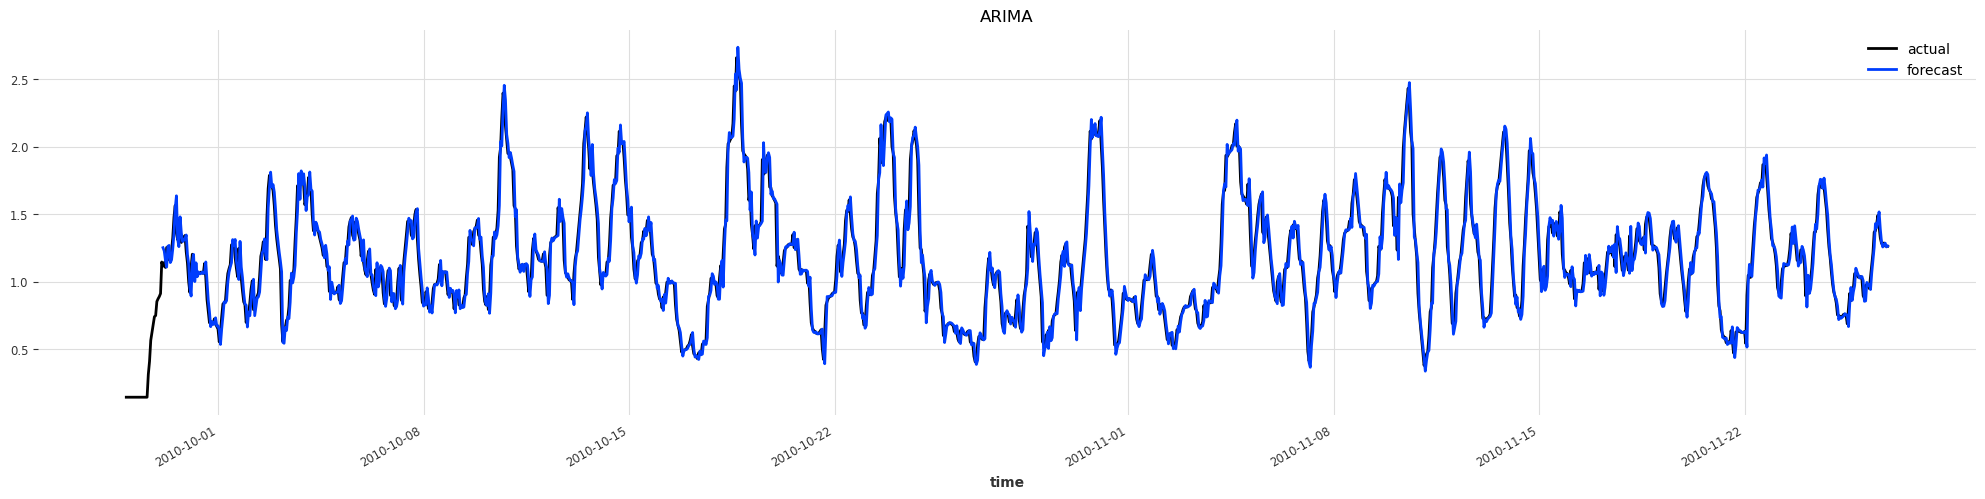

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M

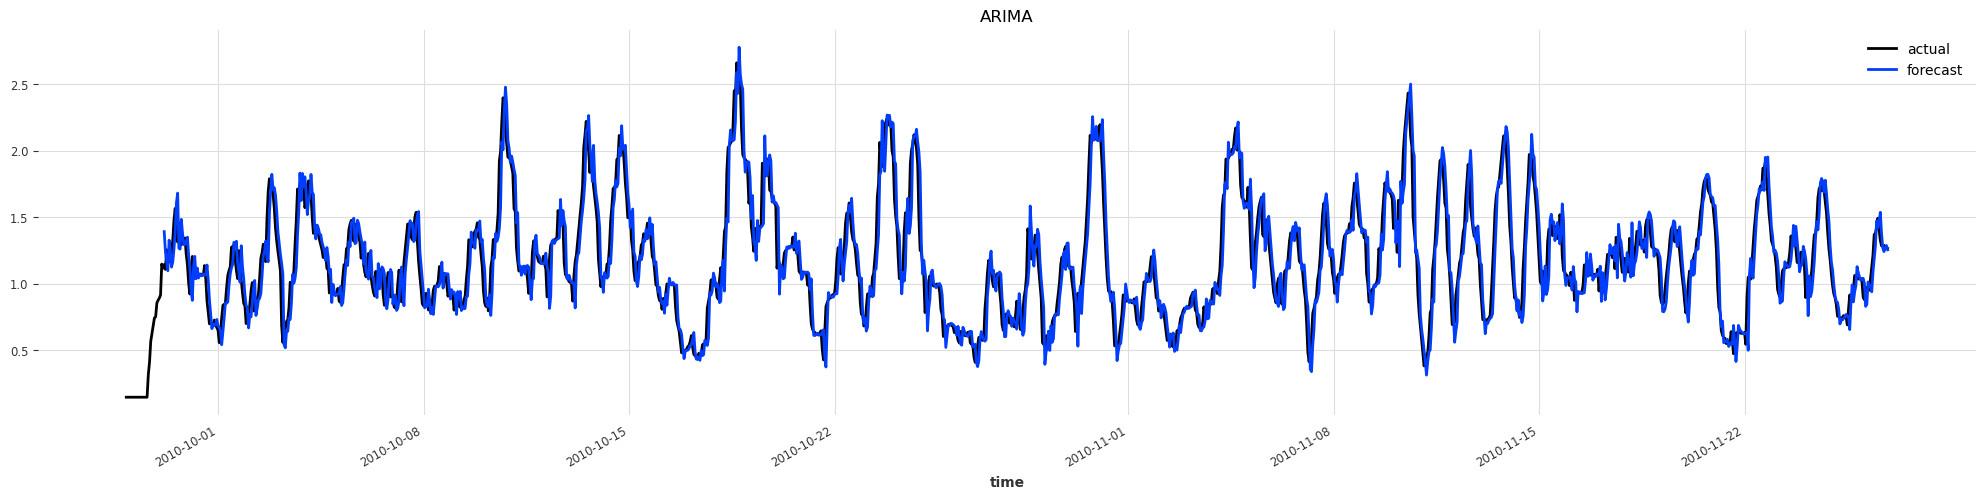

electricity_ARIMA_3.json found - skipping...


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M

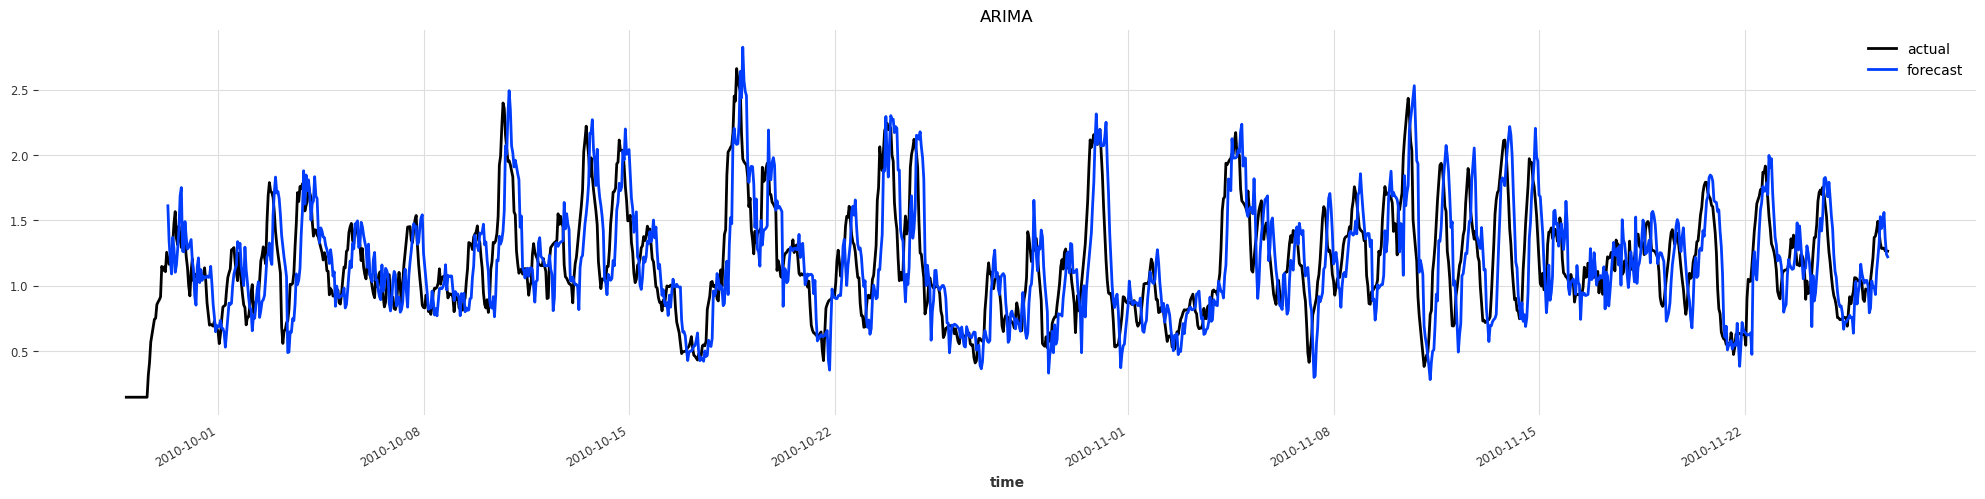

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M

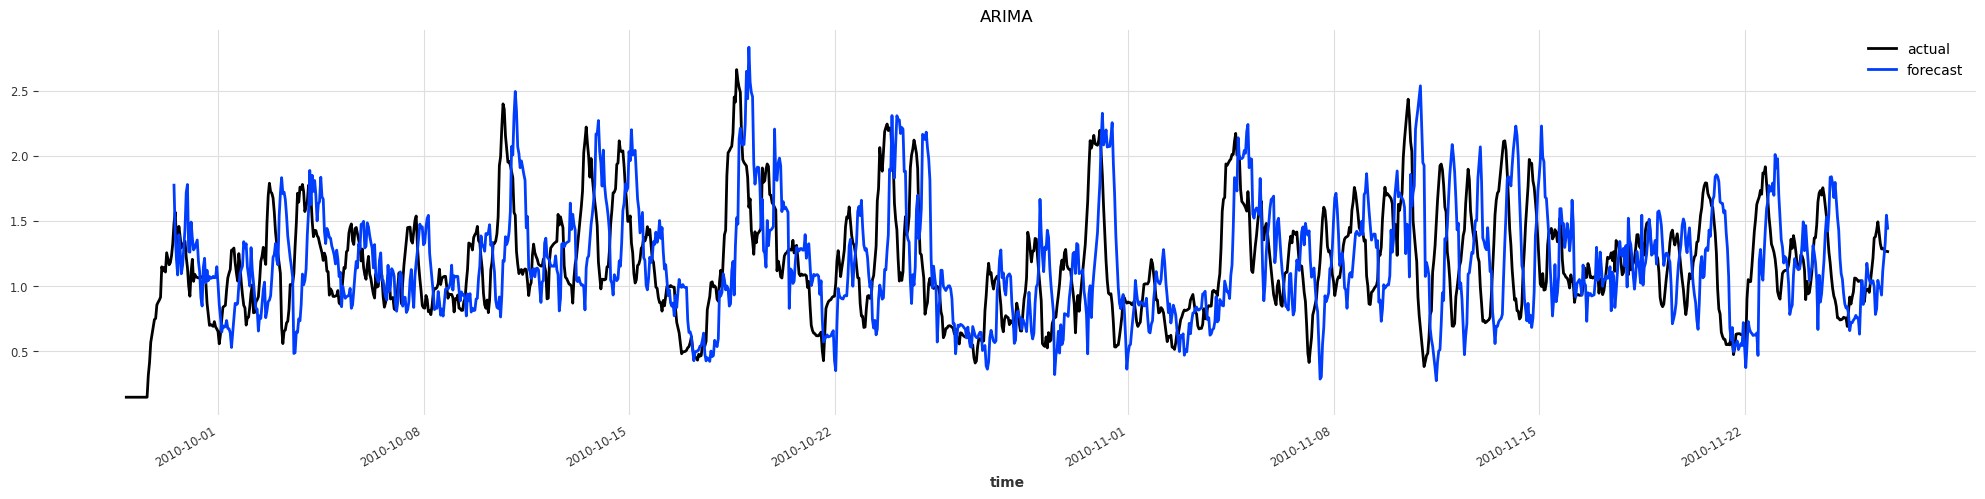

In [10]:
# arima
from darts.models import ARIMA

model = ARIMA()

for horizon in HORIZONS:
  if os.path.exists(f'results/{Electricity_Dataset.name}_{model.__class__.__name__}_{horizon}.json'):
    print(f'{Electricity_Dataset.name}_{model.__class__.__name__}_{horizon}.json', 'found - skipping...')
    continue

  experiment = TimeseriesExperiment(model, Electricity_Dataset, {
      'p': [1, 3, 5],
      'd': [1],
      'q': [0]
  }, retrain=True, forecast_horizon=horizon)

  experiment.run()